In [1]:
import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL.Image import open
import matplotlib.pyplot as plt
import copy
from tqdm import tnrange
from utils import PSNR
from functions import ObjectiveFunction

%matplotlib inline

# Objective function

Here we aim to minimize the energy function $\frac{1}{2}||z-y||^2_2 + \lambda ||\nabla_x z||_1 + \lambda ||\nabla_y z||_1$ with respect to $z$. The data fidelity term $\frac{1}{2}||z-y||^2_2$ corresponds to Gaussian denoiser problem. The regularization term is inspired by Total Variation. This problem can not be solved analytically because of L1 norm.

# Input data

In [2]:
x_gt = (ToTensor()(open('lena.png')));
y_10 = torch.clamp(x_gt + x_gt.new_empty(x_gt.shape).normal_(mean=0, std=10/100), 0, 1);

# Show me the data!

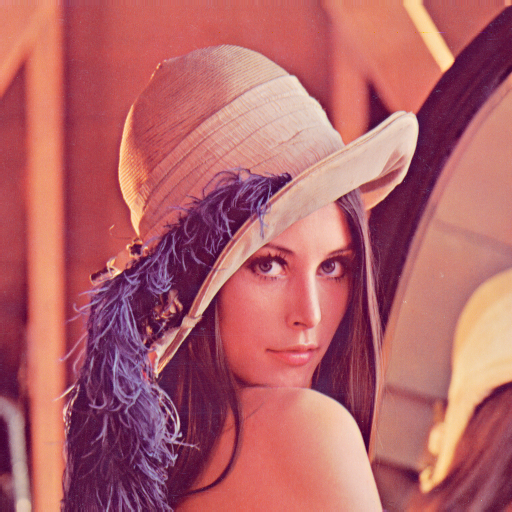

In [3]:
# ground truth image
ToPILImage()(x_gt)

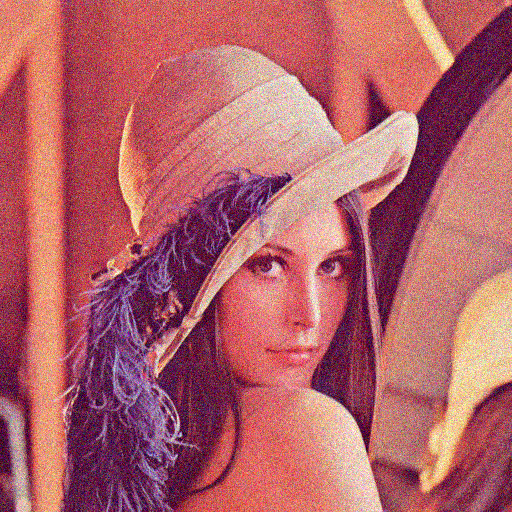

In [4]:
# noisy image
ToPILImage()(y_10)

# Restoring the denoised image

In [5]:
f = ObjectiveFunction(1e-1, 1, y_10);
opt = torch.optim.Adam([f.x], lr=1e-3);
loss = [];
loss.append(copy.deepcopy(f.forward().data));
psnrs = [];
psnrs.append(copy.deepcopy(PSNR(f.x.data, x_gt)));
for i in tnrange(500):
    f.zero_grad();
    l = f.forward();
    l.backward();
    opt.step();
    loss.append(copy.deepcopy(l.detach().data));
    psnrs.append(copy.deepcopy(PSNR(f.x.data, x_gt)));
    if psnrs[-1] > psnrs[-2]:
        x_best = copy.deepcopy(f.x.data);

# Visualize the best image obtained during restoration

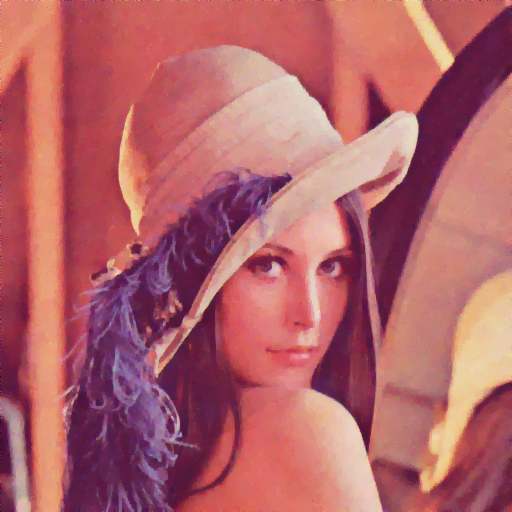

In [6]:
# the best reconstructed image in terms of PSNR
ToPILImage()(x_best)

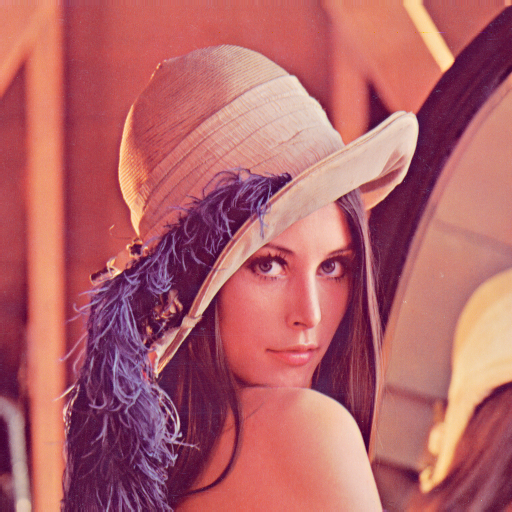

In [7]:
ToPILImage()(x_gt) # the best reconstructed image in terms of PSNR

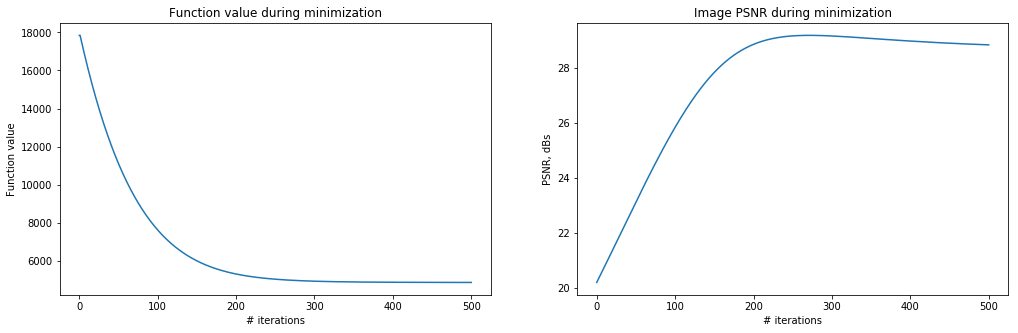

In [8]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5));
ax[0].plot(loss);
ax[0].set_title('Function value during minimization');
ax[0].set_xlabel('# iterations');
ax[0].set_ylabel('Function value');

ax[1].plot(psnrs);
ax[1].set_title('Image PSNR during minimization');
ax[1].set_xlabel('# iterations');
ax[1].set_ylabel('PSNR, dBs');

In [9]:
# print the achieved PSNR 
PSNR(x_best, x_gt)

tensor(29.1962)

# Comparison of different GD algorithms

In [ ]:
opt_methods=[
torch.optim.SGD([f.x], lr=0.01, momentum=0),
torch.optim.SGD([f.x], lr=0.01, momentum=0.9),
torch.optim.SGD([f.x], lr=0.01, momentum=0.9,nesterov=True),
torch.optim.Adam([f.x], lr=0.01),
torch.optim.Adagrad([f.x], lr=0.1),
torch.optim.Adadelta([f.x], lr=1,), 
torch.optim.RMSprop([f.x], lr=0.01)]

losses ={
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: []}

psnrs ={
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: []}

x_bests = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: []}

for j in range(len(opt_methods)):
    f = ObjectiveFunction(1e-1, 1, y_10);
    opt_methods=[
    torch.optim.SGD([f.x], lr=0.01, momentum=0),
    torch.optim.SGD([f.x], lr=0.01, momentum=0.9),
    torch.optim.SGD([f.x], lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.Adam([f.x], lr=0.01),
    torch.optim.Adagrad([f.x], lr=0.1),
    torch.optim.Adadelta([f.x], lr=1,), 
    torch.optim.RMSprop([f.x], lr=0.01)];
    
    opt = opt_methods[j];
    losses[j].append(copy.deepcopy(f.forward().data));
    psnrs[j].append(copy.deepcopy(psnr(f.x.data, x_gt)));
    for i in tnrange(500):
        f.zero_grad();
        l = f.forward();
        l.backward();
        opt.step();
        losses[j].append(copy.deepcopy(l.detach().data));
        psnrs[j].append(copy.deepcopy(psnr(f.x.data, x_gt)[0]));
        if psnrs[j][-1] > psnrs[j][-2]:
            x_bests[j] = copy.deepcopy(f.x.data);

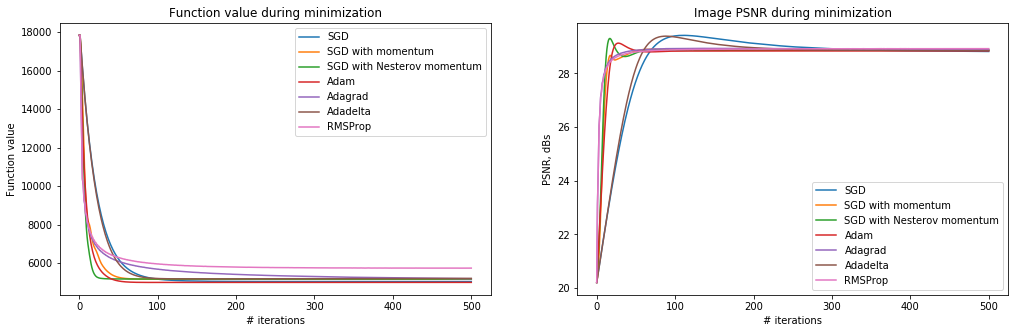

In [121]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5));
for i in range(7):
    ax[0].plot(losses[i]);
ax[0].legend(["SGD",
    "SGD with momentum",
    "SGD with Nesterov momentum",
    "Adam",
    "Adagrad",
    "Adadelta",
    "RMSProp"])
ax[0].set_title('Function value during minimization');
ax[0].set_xlabel('# iterations');
ax[0].set_ylabel('Function value');

for i in range(7):
    ax[1].plot(psnrs[i]);
ax[1].legend(["SGD",
    "SGD with momentum",
    "SGD with Nesterov momentum",
    "Adam",
    "Adagrad",
    "Adadelta",
    "RMSProp"])
ax[1].set_title('Image PSNR during minimization');
ax[1].set_xlabel('# iterations');
ax[1].set_ylabel('PSNR, dBs');